# Lexical Decision Task
Today we will try to apply the general EEG preprocessing pipeline from the MNE tutorial and the faceWord-experiment to the EEG data from the lexical decision task.


#### Setting up Python
Before starting to analyse our own EEG data, we need to make sure we have our virtual environment we created during the `MNE-tutorial`.

1. Press `Select Kernel`, then `Python Environments...` and then choose any Python kernel. 
2. Run the code chunk below
3. Change the kernel used to run the code in this notebook. Press where it says `Python X.XX.XX` in the top right corner, then `Select Another Kernel`, then `Jupyter kernel...` and then select `env`. If `env` does not show up, press the little refresh symbol! 

In [ ]:
!bash ../env_to_ipynb_kernel.sh

# Analysis of EEG data collected!
The workflow of preprocessing is as follows!
1. Load the data
2. Exclude bad channels
3. Common average reference
4. Filtering
5. Artefact rejection
6. Epoching
7. Downsampling

This is the same workflow as in the `preprocessing_tutorial.ipynb`. This notebook serves as a "skeleton" where you fill out the code you need. All code bits needed can be found in the notebook from the last class. 

<div class="alert alert-block alert-info"><b>Tip:</b>
The MNE package has some really nice documentation! If you have any questions on how to use a function or if you want to see other ways you can plot your data, have a look at it! 

https://mne.tools/stable/index.html

In [1]:
import mne
import os
import matplotlib
import numpy as np

!pip install pandas
import pandas as pd

%matplotlib inline

## 1. Load the data
As we are no longer using sample data from MNE, the process of loading the data will be a bit different. Therefore, code to help you is provided here!

In [2]:
# reading the file & loading in the data
data_folder = '/work/811462/'
group_name = "group5"

# path to the data - MAKE SURE TO CHANGE PATH ACCORDING TO YOUR GROUP NUMBER!
data_path = os.path.join(data_folder, f"{group_name}.vhdr")

raw = mne.io.read_raw_brainvision(data_path)
raw.load_data()

# set standard montage (let MNE know the layout of the electrodes on the cap)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

Extracting parameters from /work/811462/group5.vhdr...
Setting channel info structure...
Reading 0 ... 298099  =      0.000 ...   298.099 secs...


<RawBrainVision | group5.eeg, 31 x 298100 (298.1 s), ~70.6 MB, data loaded>

In [3]:
# reading in the csv file with experiment information
logfile = pd.read_csv(os.path.join(data_folder, f"subject-{group_name[-1]}.csv"))
logfile.head()

,acc,accuracy,average_response_time,avg_rt,background,canvas_backend,clock_backend,color_backend,compensation,coordinates,...,time_target_trigger,time_trial_sequence,title,total_correct,total_response_time,total_responses,trigger_interval,uniform_coordinates,width,word_response
0,100,100,442.112301,442.112301,black,psycho,psycho,psycho,0,uniform,...,NaN,NaN,Lexical decision task,1,442.112301,1,5,yes,1024,z
1,100,100,1035.682198,1035.682198,black,psycho,psycho,psycho,0,uniform,...,NaN,NaN,Lexical decision task,1,1035.682198,1,5,yes,1024,z
2,0,0,2000.023000,2000.023000,black,psycho,psycho,psycho,0,uniform,...,NaN,NaN,Lexical decision task,0,2000.023000,1,5,yes,1024,z
3,100,100,1036.917400,1036.917400,black,psycho,psycho,psycho,0,uniform,...,NaN,NaN,Lexical decision task,1,1036.917400,1,5,yes,1024,z
4,100,100,1284.172900,1284.172900,black,psycho,psycho,psycho,0,uniform,...,NaN,NaN,Lexical decision task,1,1284.172900,1,5,yes,1024,z


### Plotting the sensor layout!
Now lets plot the layout of the channels and see if it matches what you remember from making the recordings!

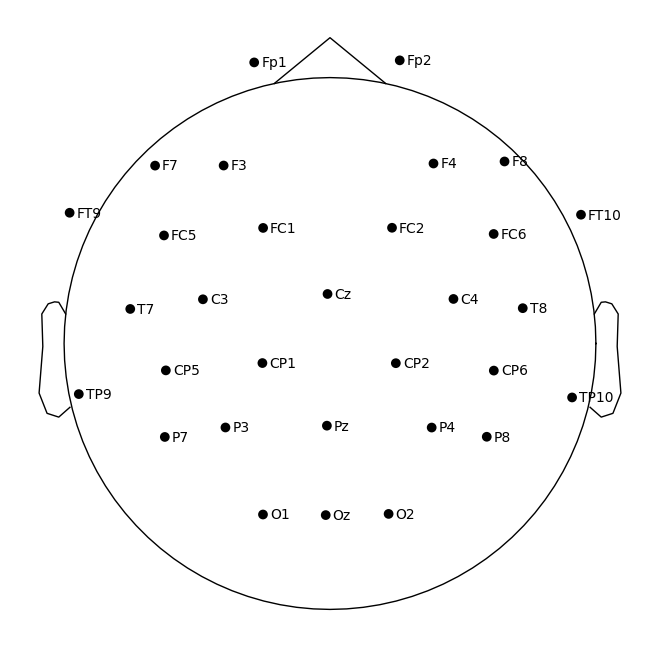

In [4]:
raw.plot_sensors(show_names=True);

## 2. Exclude bad channels

In [5]:
# sometimes filtering before plotting the channels can make it more nice to look at as we are getting rid of some noise!
# BUT IF YOU FILTER HERE NO NEED TO DO IT FURTHER ALONG :D

raw.filter(None, 40)
raw.filter(0.1, None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


<RawBrainVision | group5.eeg, 31 x 298100 (298.1 s), ~70.6 MB, data loaded>

In [ ]:
# STEP 1: Plot the raw data to help you identify bad channels
raw.plot(
    n_channels=32, 
    start=100, 
    scalings={"eeg": 250e-7}, # try modifying this value to make the plot more pleasant to look at 
    duration=10);

In [ ]:
# STEP 2: Mark bad channels as bad if there are any!

In [ ]:
# STEP 3: Remove the bad channels

## 3. Common average reference

In [6]:
# STEP 1: Choose the common average reference
raw.set_eeg_reference('average', projection=True)

# STEP 2: applying the reference to the data
raw.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawBrainVision | group5.eeg, 31 x 298100 (298.1 s), ~70.6 MB, data loaded>

## 4. Filtering

In [ ]:
# STEP 1: high-pass filtering the data at 0.1 Hz

# STEP 2: low-pass filtering at 40 Hz

# STEP 3: plot the filtered data for inspection

## 5. Artefact rejection

### ICA

In [7]:
# making a copy of the data set
raw_tmp = raw.copy()

In [ ]:
# band pass filter! 
raw_tmp.filter(l_freq=1, h_freq=40)

raw_tmp.plot(
    n_channels=32, 
    start=0, 
    scalings={"eeg": 250e-7}, # try modifying this value to make the plot more pleasant to look at 
    duration=10);

In [ ]:
# cropping the data
t_start = 10
t_end = 205

raw_tmp.crop(tmin = t_start, tmax = t_end)

In [ ]:
# resample
raw_tmp.resample(250)

In [ ]:
ica = mne.preprocessing.ICA(n_components=0.999, random_state=13, method="fastica", verbose=True)

ica.fit(raw_tmp)

In [ ]:
# plot results of ICA (time courses)
ica.plot_sources(raw, start = 30)

In [ ]:
# plot results of ICA (topomaps)
ica.plot_components()

In [ ]:
# determine noise components!
noise = [0, 1]

In [ ]:
# apply ICA to the raw data
ica.exclude = noise
ica.apply(raw)

In [ ]:
raw.plot(
    n_channels=32, 
    start=30, 
    scalings={"eeg": 250e-7}, # try modifying this value to make the plot more pleasant to look at 
    duration=10);

In [8]:
# Defining the threshold, we will apply it later when we are creating epochs
reject = dict(eeg=150e-6)# 150 µV

## 6. Epoching
This bit requires *a bit more code* today as compared yesterday, as we are experiencing some issues with the triggers. DO NOT WORRY IF THE CODE IS SUPER CONFUSING PLS

In [9]:
# STEP 1: Locate stimulus events in the recording and save it in a variable called events
events, _ = mne.events_from_annotations(raw, verbose=False)
np.unique(events[:,2])

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,  1001,  1002,  1003,
        1004,  1005,  1006,  1007,  1008,  1009,  1010,  1011,  1012,
        1013, 99999])

In [10]:
# load information from logfile
logfile['lexical_category'] = logfile['lexical_category'].replace(['word', 'nonword'], [0, 2])
logfile['prime_category'] = logfile['prime_category'].replace(['congruent', 'incongruent'], [0, 1])
logfile['target_category'] = logfile['target_category'].replace(['practice', 'compound_first', 'basic',
                                                                 'filler', 'abstract', 'subordinate', 
                                                                 'nontransparent_last', 'nontransparent_first', 
                                                                 'compound_last'], [90, 50, 20, 10, 80, 30,
                                                                                   60, 70, 40])

In [11]:
# INCLUDE 3
logfile['event'] = logfile['lexical_category'] + logfile['prime_category'] + logfile['target_category']

logfile['event_rt'] = logfile['correct'].replace([1, 0], [100, 105])
logfile['event_rt'] = logfile['event_rt'] + logfile['event']

# separate time for the button presses
logfile['event_rt_time'] = logfile['time_target'] + logfile['response_time_keyboard_response']


In [12]:
temp = []
for ev, resp in zip(logfile['event'], logfile['event_rt']):
    temp.append(ev+5)
    temp.append(ev)
    temp.append(resp)

print(len(temp))

219


In [13]:
time_time = []

for p, t, r in zip(logfile['time_prime_trigger'][12:], logfile['time_target_trigger'][12:], logfile['time_resp_trigger'][12:]):
    time_time.append(p)
    time_time.append(t)
    time_time.append(r)

print(len(time_time))

183


In [14]:
temp_time = []

for p, t, r in zip(logfile['time_prac_prime_trigger'][:12], logfile['time_prac_target_trigger'][:12], logfile['time_prac_resp_trigger'][:12]):
    temp_time.append(p)
    temp_time.append(t)
    temp_time.append(r)
print(len(temp_time))

36


In [15]:
new_events = events
temp_dif = np.append(1, np.diff(new_events[:,0])) 
tempi = np.where(temp_dif==0)[0]-1
new_events = np.delete(new_events,tempi,0)

In [24]:
real_events = new_events
real_events[5:14*3-1,2] = temp[:36]
real_events[14*3:-1,2] = temp[36:]

In [19]:
# STEP 2: Create an event dictionary
event_id = {'filler/congruent/word/target': 10, # filler word with congruent prime
            'filler/congruent/nonword/target': 12, # filler nonword with congruent prime
            'filler/congruent/word/correct': 110, # filler word with congruent prime - correct answer
            'filler/congruent/word/incorrect': 115, # filler word with congruent prime - incorrect answer
            'filler/congruent/nonword/correct': 112, # filler non-word with congruent prime - correct answer
            'filler/congruent/nonword/incorrect': 117, # filler non-word with congruent prime - incorrect answer
            'filler/incongruent/word/target': 11, # filler word with incongruent prime
            'filler/incongruent/nonword/target': 13, # filler nonword with incongruent prime
            'filler/incongruent/word/correct': 111, # filler word with incongruent prime - correct answer
            'filler/incongruent/word/incorrect': 116, # filler word with incongruent prime - incorrect answer
            'filler/incongruent/nonword/correct': 113, # filler non-word with incongruent prime - correct answer
            'filler/incongruent/nonword/incorrect': 118, # filler non-word with incongruent prime - incorrect answer
            'basic/congruent/word/target': 20, # basic-category word with congruent prime
            'basic/congruent/nonword/target': 22, # basic-category nonword with congruent prime
            'basic/congruent/word/correct': 120, # basic-category word with congruent prime - correct answer
            'basic/congruent/word/incorrect': 125, # basic-category word with congruent prime - incorrect answer
            'basic/congruent/nonword/correct': 122, # basic-category non-word with congruent prime - correct answer
            'basic/congruent/nonword/incorrect': 127, # basic-category non-word with congruent prime - incorrect answer
            'basic/incongruent/word/target': 21, # basic-category word with incongruent prime
            'basic/incongruent/nonword/target': 23, # basic-category nonword with incongruent prime
            'basic/incongruent/word/correct': 121, # basic-category word with incongruent prime - correct answer
            'basic/incongruent/word/incorrect': 126, # basic-category word with incongruent prime - incorrect answer
            'basic/incongruent/nonword/correct': 123, # basic-category non-word with incongruent prime - correct answer
            'basic/incongruent/nonword/incorrect': 128, # basic-category non-word with incongruent prime - incorrect answer
            'subordinate/congruent/word/target': 30, # subordinate word with congruent prime
            'subordinate/congruent/nonword/target': 32, # subordinate nonword with congruent prime
            'subordinate/congruent/word/correct': 130, # subordinate word with congruent prime - correct answer
            'subordinate/congruent/word/incorrect': 135, # subordinate word with congruent prime - incorrect answer
            'subordinate/congruent/nonword/correct': 132, # subordinate non-word with congruent prime - correct answer
            'subordinate/congruent/nonword/incorrect': 137, # subordinate non-word with congruent prime - incorrect answer
            'subordinate/incongruent/word/target': 31, # subordinate word with incongruent prime
            'subordinate/incongruent/nonword/target': 33, # subordinate nonword with incongruent prime
            'subordinate/incongruent/word/correct': 131, # subordinate word with incongruent prime - correct answer
            'subordinate/incongruent/word/incorrect': 136, # subordinate word with incongruent prime - incorrect answer
            'subordinate/incongruent/nonword/correct': 133, # subordinate non-word with incongruent prime - correct answer
            'subordinate/incongruent/nonword/incorrect': 138, # subordinate non-word with incongruent prime - incorrect answer
            'compoundlast/congruent/word/target': 40, # compound-last word with congruent prime
            'compoundlast/congruent/nonword/target': 42, # compound-last nonword with congruent prime
            'compoundlast/congruent/word/correct': 140, # compound-last word with congruent prime - correct answer
            'compoundlast/congruent/word/incorrect': 145, # compound-last word with congruent prime - incorrect answer
            'compoundlast/congruent/nonword/correct': 142, # compound-last non-word with congruent prime - correct answer
            'compoundlast/congruent/nonword/incorrect': 147, # compound-last non-word with congruent prime - incorrect answer
            'compoundlast/incongruent/word/target': 41, # compound-last word with incongruent prime
            'compoundlast/incongruent/nonword/target': 43, # compound-last nonword with incongruent prime
            'compoundlast/incongruent/word/correct': 141, # compound-last word with incongruent prime - correct answer
            'compoundlast/incongruent/word/incorrect': 146, # compound-last word with incongruent prime - incorrect answer
            'compoundlast/incongruent/nonword/correct': 143, # compound-last non-word with incongruent prime - correct answer
            'compoundlast/incongruent/nonword/incorrect': 148, # compound-last non-word with incongruent prime - incorrect answer
            'compoundfirst/congruent/word/target': 50, # compound-first word with congruent prime
            'compoundfirst/congruent/nonword/target': 52, # compound-first nonword with congruent prime
            'compoundfirst/congruent/word/correct': 150, # compound-first word with congruent prime - correct answer
            'compoundfirst/congruent/word/incorrect': 155, # compound-first word with congruent prime - incorrect answer
            'compoundfirst/congruent/nonword/correct': 152, # compound-first non-word with congruent prime - correct answer
            'compoundfirst/congruent/nonword/incorrect': 157, # compound-first non-word with congruent prime - incorrect answer
            'compoundfirst/incongruent/word/target': 51, # compound-first word with incongruent prime
            'compoundfirst/incongruent/nonword/target': 53, # compound-first nonword with incongruent prime
            'compoundfirst/incongruent/word/correct': 151, # compound-first word with incongruent prime - correct answer
            'compoundfirst/incongruent/word/incorrect': 156, # compound-first word with incongruent prime - incorrect answer
            'compoundfirst/incongruent/nonword/correct': 153, # compound-first non-word with incongruent prime - correct answer
            'compoundfirst/incongruent/nonword/incorrect': 158, # compound-first non-word with incongruent prime - incorrect answer
            'nontransparentlast/congruent/word/target': 60, # nontransparent compound-last word with congruent prime
            'nontransparentlast/congruent/nonword/target': 62, # nontransparent compound-last nonword with congruent prime
            'nontransparentlast/congruent/word/correct': 160, # nontransparent compound-last word with congruent prime - correct answer
            'nontransparentlast/congruent/word/incorrect': 165, # nontransparent compound-last word with congruent prime - incorrect answer
            'nontransparentlast/congruent/nonword/correct': 162, # nontransparent compound-last non-word with congruent prime - correct answer
            'nontransparentlast/congruent/nonword/incorrect': 167, # nontransparent compound-last non-word with congruent prime - incorrect answer
            'nontransparentlast/incongruent/word/target': 61, # nontransparent compound-last word with incongruent prime
            'nontransparentlast/incongruent/nonword/target': 63, # nontransparent compound-last nonword with incongruent prime
            'nontransparentlast/incongruent/word/correct': 161, # nontransparent compound-last word with incongruent prime - correct answer
            'nontransparentlast/incongruent/word/incorrect': 166, # nontransparent compound-last word with incongruent prime - incorrect answer
            'nontransparentlast/incongruent/nonword/correct': 163, # nontransparent compound-last non-word with incongruent prime - correct answer
            'nontransparentlast/incongruent/nonword/incorrect': 168, # nontransparent compound-last non-word with incongruent prime - incorrect answer
            'nontransparentfirst/congruent/word/target': 70, # nontransparent compound-first word with congruent prime
            'nontransparentfirst/congruent/nonword/target': 72, # nontransparent compound-first nonword with congruent prime
            'nontransparentfirst/congruent/word/correct': 170, # nontransparent compound-first word with congruent prime - correct answer
            'nontransparentfirst/congruent/word/incorrect': 175, # nontransparent compound-first word with congruent prime - incorrect answer
            'nontransparentfirst/congruent/nonword/correct': 172, # nontransparent compound-first non-word with congruent prime - correct answer
            'nontransparentfirst/congruent/nonword/incorrect': 177, # nontransparent compound-first non-word with congruent prime - incorrect answer
            'nontransparentfirst/incongruent/word/target': 71, # nontransparent compound-first word with incongruent prime
            'nontransparentfirst/incongruent/nonword/target': 73, # nontransparent compound-first nonword with incongruent prime
            'nontransparentfirst/incongruent/word/correct': 171, # nontransparent compound-first word with incongruent prime - correct answer
            'nontransparentfirst/incongruent/word/incorrect': 176, # nontransparent compound-first word with incongruent prime - incorrect answer
            'nontransparentfirst/incongruent/nonword/correct': 173, # nontransparent compound-first non-word with incongruent prime - correct answer
            'nontransparentfirst/incongruent/nonword/incorrect': 178, # nontransparent compound-first non-word with incongruent prime - incorrect answer
            'abstract/congruent/word/target': 80, # abstract word with congruent prime
            'abstract/congruent/nonword/target': 82, # abstract word with congruent prime
            'abstract/congruent/word/correct': 180, # abstract word with congruent prime - correct answer
            'abstract/congruent/word/incorrect': 185, # abstract word with congruent prime - incorrect answer
            'abstract/congruent/nonword/correct': 182, # abstract non-word with congruent prime - correct answer
            'abstract/congruent/nonword/incorrect': 187, # abstract non-word with congruent prime - incorrect answer
            'abstract/incongruent/word/target': 81, # abstract word with incongruent prime
            'abstract/incongruent/nonword/target': 83, # abstract fumbelword with incongruent prime
            'abstract/incongruent/word/correct': 181, # abstract word with incongruent prime - correct answer
            'abstract/incongruent/word/incorrect': 186, # abstract word with incongruent prime - incorrect answer
            'abstract/incongruent/nonword/correct': 183, # abstract non-word with incongruent prime - correct answer
            'abstract/incongruent/nonword/incorrect': 188, # abstract non-word with incongruent prime - incorrect answer
            'practice/congruent/word/target': 90, # practice word with congruent prime
            'practice/congruent/nonword/target': 92, # practice word with congruent prime
            'practice/congruent/word/correct': 190, # practice word with congruent prime - correct answer
            'practice/congruent/word/incorrect': 195, # practice word with congruent prime - incorrect answer
            'practice/congruent/nonword/correct': 192, # practice non-word with congruent prime - correct answer
            'practice/congruent/nonword/incorrect': 197, # practice non-word with congruent prime - incorrect answer
            'practice/incongruent/word/target': 91, # practice word with incongruent prime
            'practice/incongruent/nonword/target': 93,                                  # practice word with congruent prime
            'practice/incongruent/word/correct': 191, # practice word with incongruent prime - correct answer
            'practice/incongruent/word/incorrect': 196, # practice word with incongruent prime - incorrect answer
            'practice/incongruent/nonword/correct': 193, # practice non-word with incongruent prime - correct answer
            'practice/incongruent/nonword/incorrect': 198 # practice non-word with incongruent prime - incorrect answer
           }

In [20]:
# modify event id so we only have triggers from our data so we do not get an error when we are trying to run 
triggers_unique = np.unique(real_events[:, 2])

# Create a new dictionary for the selected triggers
updated_event_ids = {}

# Iterate through the event_id dictionary
for key, value in event_id.items():
    if value in triggers_unique:
        updated_event_ids[key] = value

print(updated_event_ids)


{'filler/congruent/word/target': 10, 'filler/congruent/nonword/target': 12, 'filler/congruent/word/correct': 110, 'filler/congruent/word/incorrect': 115, 'filler/congruent/nonword/correct': 112, 'filler/congruent/nonword/incorrect': 117, 'filler/incongruent/word/target': 11, 'filler/incongruent/nonword/target': 13, 'filler/incongruent/word/correct': 111, 'filler/incongruent/word/incorrect': 116, 'filler/incongruent/nonword/correct': 113, 'filler/incongruent/nonword/incorrect': 118, 'basic/congruent/word/target': 20, 'basic/congruent/nonword/target': 22, 'basic/congruent/word/correct': 120, 'basic/congruent/nonword/correct': 122, 'basic/congruent/nonword/incorrect': 127, 'basic/incongruent/word/target': 21, 'basic/incongruent/nonword/target': 23, 'basic/incongruent/word/correct': 121, 'basic/incongruent/word/incorrect': 126, 'basic/incongruent/nonword/correct': 123, 'basic/incongruent/nonword/incorrect': 128, 'subordinate/congruent/word/target': 30, 'subordinate/congruent/nonword/target

In [21]:
# STEP 3: establish a time window for epochs
tmin = -0.2
tmax = 1

In [22]:
# STEP 4: Create the epochs
epochs = mne.Epochs(
    raw, 
    real_events,
    event_id = updated_event_ids, 
    tmin = tmin, 
    tmax = tmax, 
    picks=["eeg"],
    baseline=(None, 0), 
    reject=reject, 
    preload=True
    )

Not setting metadata
147 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 147 events and 1201 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'TP9', 'P7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2'

KeyboardInterrupt: 

**At this point call Laura over to have a look!**

## 7. Downsampling

In [ ]:
# STEP 1: Downsample to 250 Hz

# Analysis
Using the logic from yesterdays class try and come up with different trial types that would be interesting to compare and contrast